# Ensemble learning

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score

### Używając PCA transformujemy podzbiór MNIST do przestrzeni 30D

In [2]:
mnist = fetch_openml("mnist_784", data_home="data/mnist_784", cache=True)

In [3]:
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)

In [4]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

### Wybieramy ze zbioru dwie trudno rozdzielalne klasy. Będą to zbiory danych do następnych ćwiczeń.

In [5]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)

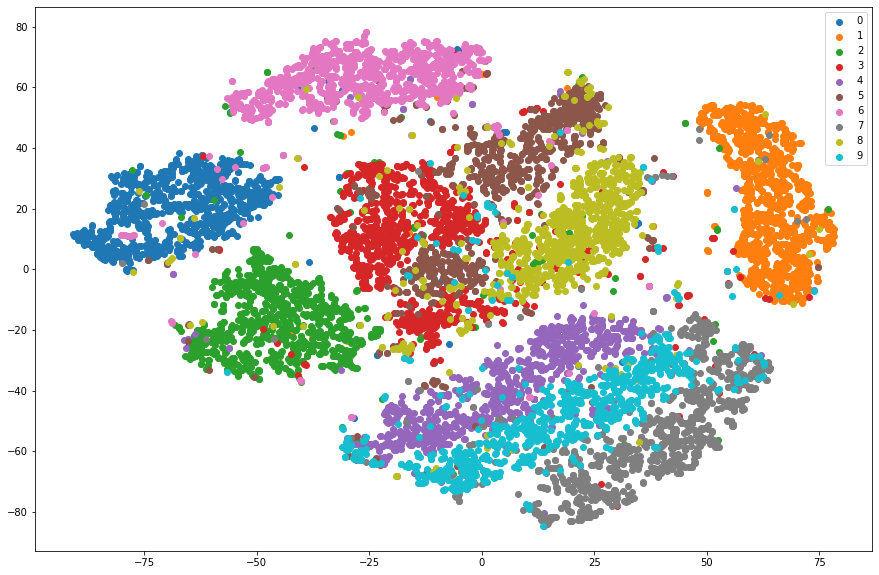

In [6]:
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

Jak widać na powyższym wykresie istnieją klasy, które wzajemnie na siebie nachodzą.\
Przykładem mogą być:
    - 3 i 8
    - 3 i 5
    - 5 i 8
    - 4 i 9
    - 7 i 9
Do dalszych zadań wybieramy klasę 3 i 8 

In [7]:
digit_filter = np.where((y == '3') | (y == '8'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1609, 30)

## Bagging

Każdy z 5 klasyfikatorów jest trenowany za pomocą pozdbioru o wielkości 40% calego zbioru.

In [9]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9702233250620348

Definujemy fukncje pomocnicze do obliczania wyników klasyfikacji oraz ich graficznej prezentacji

In [10]:
def ensemble(Clf, estimators=[5], samples=[0.9], features=[0.9], params={}):
    result = pd.DataFrame(columns=['n_estimators', 'max_features', 'max_samples', 'score_f1', 'score'])
    for n_estimators in estimators:
        for max_samples in samples:
            for max_features in features:
                clf = Clf(max_features=max_features, n_estimators=n_estimators, max_samples=max_samples, **params)
                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)
                row = { 'n_estimators':n_estimators,
                        'max_samples':max_samples,
                        'max_features':max_features,
                        'score': clf.score(x_test, y_test),
                        'score_f1': f1_score(y_test, pred, average='weighted')
                      }
                result = result.append(row, ignore_index=True)
    return result

    
def draw_heatmap(param1, param2, df, score='score'):
    score = df.pivot(param1, param2, score)
    plt.figure(figsize=(10,10))
    sns.heatmap(score,annot=True,cmap="YlGnBu")

Obserwujemy zmianę dokładności klasyfikacji i F1 dla wzrastającej liczby klasyfikatorów w zespole i liczby przykładów, na których uczone są klasyfikatory proste.

In [11]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True}
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.942921,0.942928
1,5.0,0.9,0.2,0.957816,0.957816
2,5.0,0.9,0.3,0.962770,0.962779
3,5.0,0.9,0.4,0.962770,0.962779
4,5.0,0.9,0.5,0.960284,0.960298
...,...,...,...,...,...
95,50.0,0.9,0.6,0.967741,0.967742
96,50.0,0.9,0.7,0.965260,0.965261
97,50.0,0.9,0.8,0.970223,0.970223
98,50.0,0.9,0.9,0.967741,0.967742


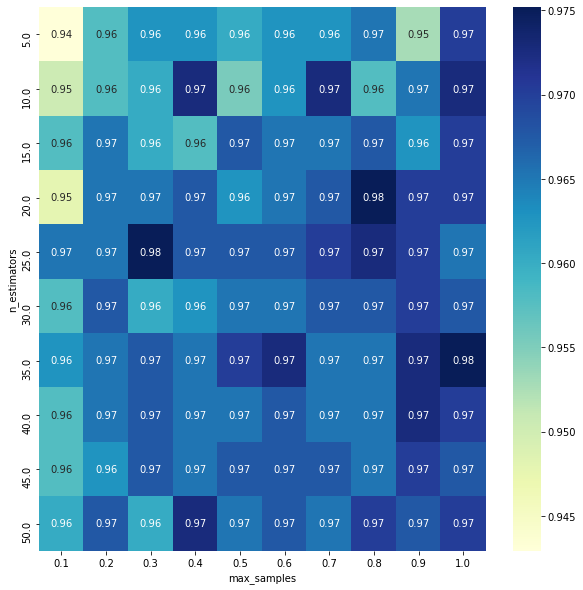

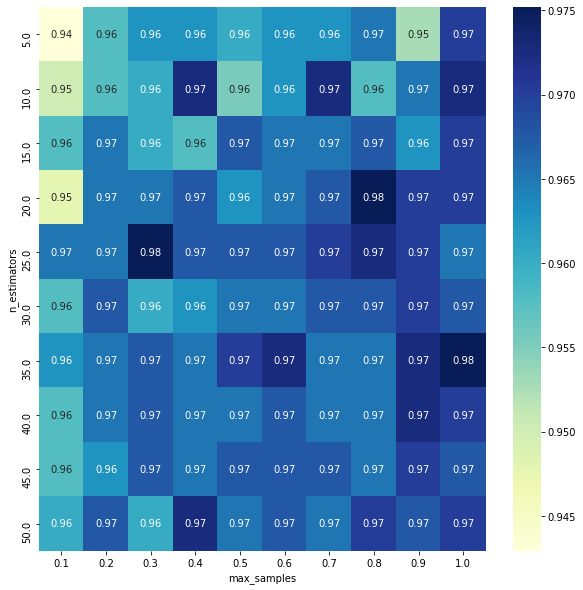

In [12]:
# dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji (normalna średnia, majority voting, etc.)

## Random Subspaces
Do trenowania każdego z klasyfikatorów wykorzystany jest cały zbiór danych, lecz tylko połowa cech.

In [13]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9553349875930521

Teraz obserwujemy zmienę dokładność klasyfikacji i F1 dla Random Subspace.

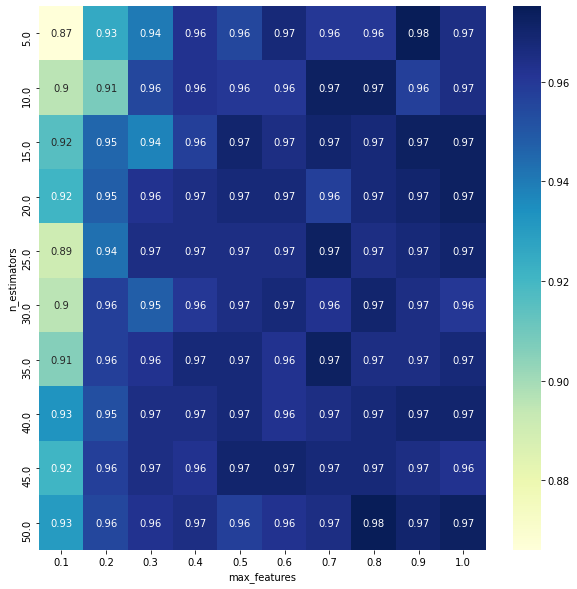

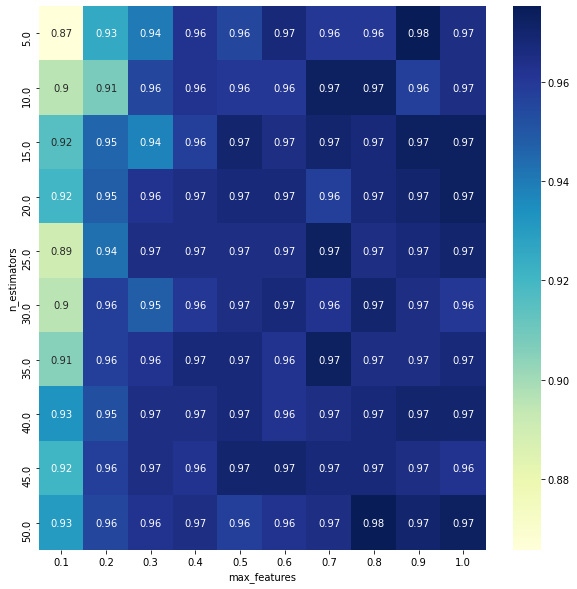

In [14]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True}

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

#### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji (normalna średnia, majority voting, etc.)

## Połącznie baggingu oraz random subspace
Każdy z klasyfikatorów jest trenowany na podzbiorze danych oraz podzbiorze cech.


In [15]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9553349875930521

Teraz obserwujemy zmianę dokładności klasyfikacji i F1.

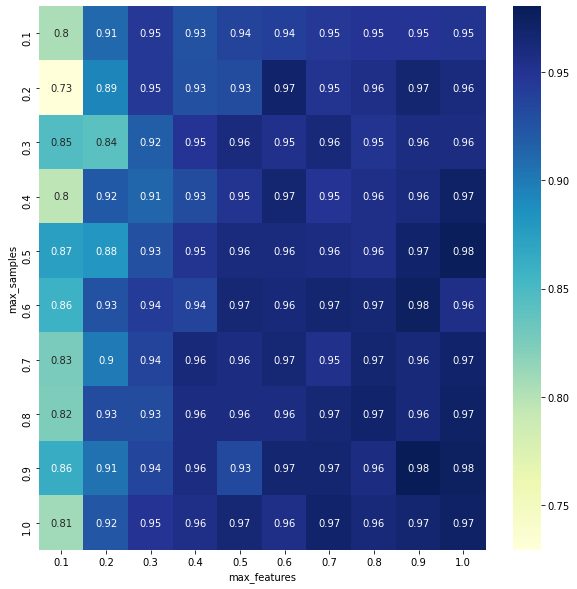

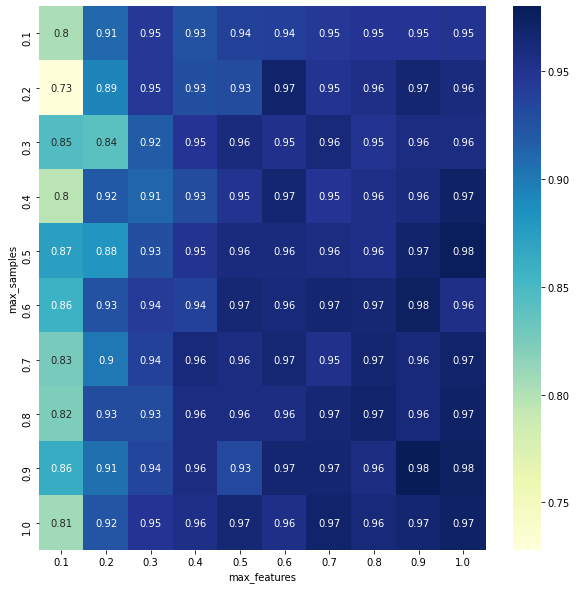

In [16]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True}

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

#### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji (normalna średnia, majority voting, etc.)

## AdaBoost

In [17]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8535980148883374

## Random Forest

In [18]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9305210918114144

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla Random Forest.


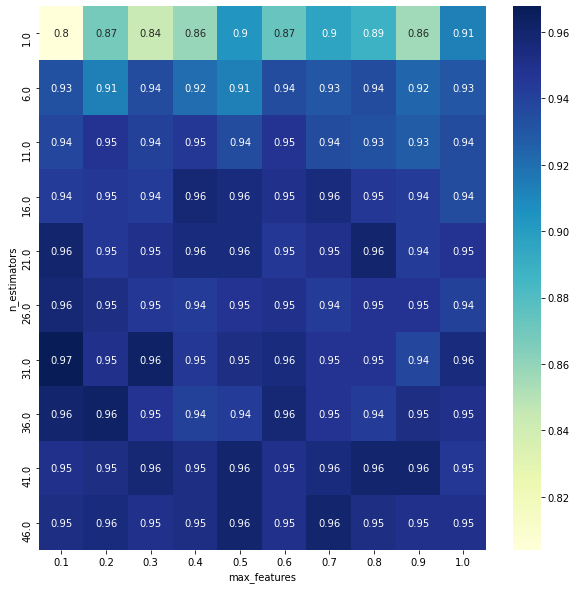

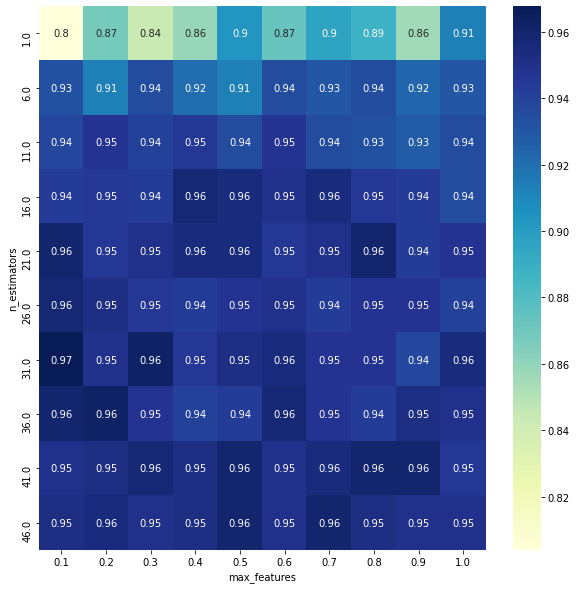

In [19]:
estimators = range(1, 50, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

## Zadanie indywidualne

1. Przetransformować zbiór FMNIST używając PCA do przestrzeni 30D. Następnie wybrać 2 trudno rozdzielane klasy

2. Sprawdzić jak działa klasyczny bagging dla 5 klasyfikatorów prostych. Następnie określić:\
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i liczby           przykładów, na których są uczone klasyfikatory\
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji (averaging/voting)

3. Analogicznie do punktu 2, tylko tym razem dla random subspace

4. Analogicznie do punktu 2, tylko tym razem dla równocześnie baggingu oraz random subspace (wybrać stałą liczbę klasyfikatorów)

5. Analogicznie do punktu 2a, tylko tym razem dla AdaBoost

6. Analogicznie do punktu 2a, tylko tym razem dla RandomForest